In [1]:
import sys
import os
import pandas as pd
from os import path

import pickle
from IPython.core.display import display, HTML, Markdown

sys.path.append(os.path.abspath("../../ml/"))

from apply_loocv_and_save import *
from dev_wtp_io_utils import *
import gc
import nibabel as nib

nonbids_data_path = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/"
ml_data_folderpath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml"
train_test_markers_filepath = ml_data_folderpath + "/train_test_markers_20210601T183243.csv"
test_train_df = pd.read_csv(train_test_markers_filepath)

all_sst_events= pd.read_csv(ml_data_folderpath +"/SST/" + "all_sst_events.csv")


dataset_name = 'posterror_conditions'

from nilearn.decoding import DecoderRegressor, Decoder

script_path = '/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml'
# HRF 2s

#get a PFC mask
#pfc_mask = create_mask_from_images(get_pfc_image_filepaths(ml_data_folderpath + "/"),threshold=10)
#get the masks we want




python initialized for apply_loocv_and_save


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


4


In [2]:
from analyze_results import remove_selected_outliers_rtfs_study

In [3]:
background_img = nlt.Brain_Data('/projects/sanlab/shared/spm12/canonical/MNI152_T1_1mm_brain.nii').to_nifti()

neurosynth_emo_reg_mask = nlt.Brain_Data(ml_data_folderpath + '/masks/emotion regulation_association-test_z_FDR_0.01.nii.gz').threshold(binarize=True).to_nifti()
neurosynth_error_mask = nlt.Brain_Data(ml_data_folderpath + '/masks/error_association-test_z_FDR_0.01.nii.gz').threshold(binarize=True).to_nifti()
accmask = nlt.Brain_Data(ml_data_folderpath + '/masks/harvardoxford-cortical_prob_Cingulate Gyrus, anterior division.nii.gz').threshold(binarize=True,upper=25).to_nifti()

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


In [4]:
from analyze_results import plot_stat_maps, get_bd, visualize_corr, get_ind_div_for_pes_combined, create_histogram

In [5]:
def run_full_pes_analysis_no_male_specific(mask_label,mask_file,similarity_method):
    dataset_mask_label = mask_label
    relevant_mask = mask_file
    results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_84subs_twoclasses_" + dataset_mask_label +".pkl"
    brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_posterror_conditions_84subs_correct_cond.pkl'

    plotting.plot_img(
        relevant_mask,
        threshold='auto',
        cmap='autumn',
        bg_img=background_img)


    print(results_filepath)
    results=pickle.load(open(results_filepath,'rb'))

    print(np.mean(results[0]))

    PostCorrect_ns=results[3]['CorrectGoFollowingCorrectStop']
    #display(Markdown("### CorrectGoFollowingCorrectStop"))
    plotting.plot_img(PostCorrect_ns,threshold='auto',bg_img=background_img)

    PostError_ns=results[3]['CorrectGoFollowingFailedStop']
    #display(Markdown("### CorrectGoFollowingFailedStop"))
    plotting.plot_img(PostError_ns,threshold='auto',bg_img=background_img)

    print(results_filepath,flush=True)

    print("plotting signatures")

    plot_stat_maps(PostError_ns,PostCorrect_ns)

    print("loading data")

    bd=get_bd(brain_data_filepath,PostError_ns,PostCorrect_ns,relevant_mask,similarity_method=similarity_method)

    create_histogram(bd)

    ind_div_combined = get_ind_div_for_pes_combined(bd,ml_data_folderpath)

    ind_div_combined = remove_selected_outliers_rtfs_study(ind_div_combined,show_plot=False)

    for neural_var in ['PE_trials_PostError_similarity','PC_trials_PostCorrect_similarity']:
        display(Markdown("### " + neural_var))
        for correlate in ['RTFS_f1_minus_f2','RTFS_factor_1','RTFS_factor_2','SST_SSRT','pes_mean_limited','PostErrorSlowW1','cancer_promoting_minus_preventing_FFQ',
            'cancer_promoting_FFQ','cancer_preventing_FFQ']:
            visualize_corr(neural_var,correlate,ind_div_combined)
            
    for bs_f in ['Female']:
        display(Markdown("### " + bs_f))
        for neural_var in ['PE_trials_PostError_similarity','PC_trials_PostCorrect_similarity']:
            display(Markdown("#### " + neural_var))
            for correlate in ['RTFS_f1_minus_f2','RTFS_factor_1','RTFS_factor_2','SST_SSRT','pes_mean_limited','PostErrorSlowW1','cancer_promoting_minus_preventing_FFQ',
        'cancer_promoting_FFQ','cancer_preventing_FFQ']:
                visualize_corr(neural_var,correlate,ind_div_combined.loc[ind_div_combined.birthsex_factor==bs_f,:])




In [14]:
from scipy.stats import pearsonr, spearmanr

import matplotlib.pyplot as plt
from matplotlib import pyplot

def visualize_corr(neural_var,correlate,data):
    display(HTML(correlate))
    #nan_rows = np.isnan(data[correlate])
    nan_rows = np.isnan(data[correlate]) | np.isnan(data[neural_var])
    cor2way_df = data.loc[nan_rows==False,]
    pearson_result = pearsonr(cor2way_df[neural_var],cor2way_df[correlate])
    display(HTML("r=" + format(pearson_result[0],".2f") +"; p-value=" + format(pearson_result[1],".4f")))
    spearman_result = spearmanr(cor2way_df[neural_var],cor2way_df[correlate])
    display(HTML("rho=" + format(spearman_result[0],".2f") +"; p-value=" + format(spearman_result[1],".4f")))
    cplot = plt.scatter(cor2way_df[neural_var],cor2way_df[correlate])
    cplot.axes.set_xlabel(neural_var)
    cplot.axes.set_ylabel(correlate)
    pyplot.show()

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_wholebrain.pkl
0.8888888888888888
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_wholebrain.pkl
plotting signatures


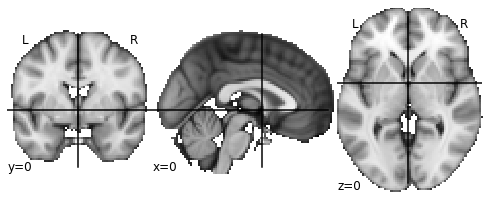

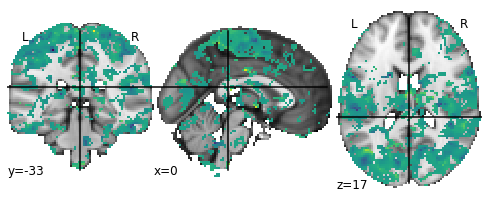

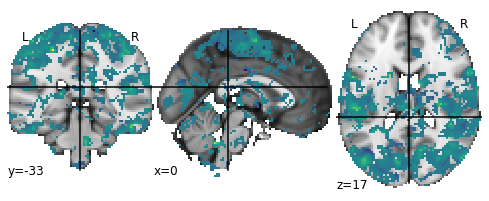

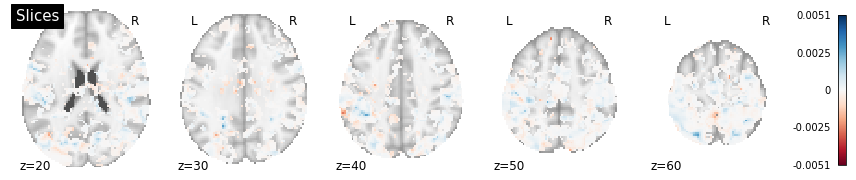

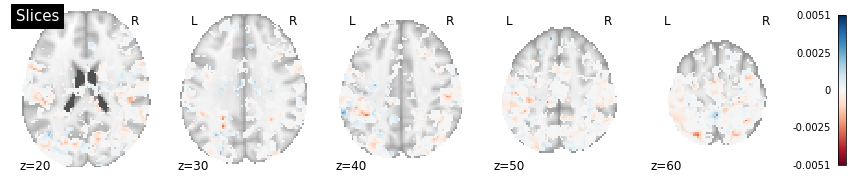

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


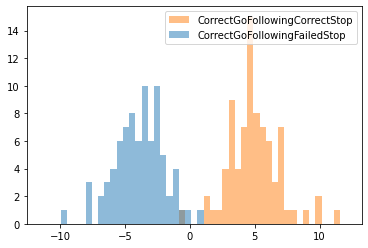

,PostError_similarity,PostCorrect_similarity
condition_label,,
CorrectGoFollowingCorrectStop,4.969145,-4.969145
CorrectGoFollowingFailedStop,-4.627246,4.627246


0.009232456815562565 0.07499674494725306 -0.0657642881316905 0.08422920176281562


0.009232456815562565 0.07499674494725306 -0.0657642881316905 0.08422920176281562
66 , 60
0.00542666014271937 0.07267931990910022 -0.06725265976638085 0.07810598005181958
60 , 59
0.00470075519842794 0.07130647499379199 -0.06660571979536405 0.07600723019221993
59 , 59


66 , 65
65 , 65


0.04934769830378225 0.16000871055522017 -0.11066101225143793 0.20935640885900242


0.04934769830378225 0.16000871055522017 -0.11066101225143793 0.20935640885900242
66 , 64
0.04934769830378225 0.1599415802788834 -0.11059388197510114 0.20928927858266563
64 , 64


66 , 65
65 , 64
64 , 64


1606.8330282933334 4748.65773553835 -3141.8247072450163 6355.490763831684


1606.8330282933334 4748.65773553835 -3141.8247072450163 6355.490763831684
30 , 27
1424.959268 3614.4890078448952 -2189.529739844895 5039.448275844896
27 , 27


30 , 28
28 , 27
27 , 27


4.872617978045989 5.159237045882512 -0.286619067836523 10.0318550239285


4.872617978045989 5.159237045882512 -0.286619067836523 10.0318550239285
81 , 79
4.872617978045989 5.008704169924817 -0.1360861918788281 9.881322147970806
79 , 78
4.8581368636266165 4.778723644000115 0.07941321962650161 9.636860507626732
78 , 77
4.843655749207244 4.697860067994084 0.14579568121316022 9.541515817201327
77 , 77


81 , 80
80 , 79
79 , 79


-3.8214337347524667 5.6639886574443405 -9.485422392196806 1.8425549226918738


-3.8214337347524667 5.6639886574443405 -9.485422392196806 1.8425549226918738
81 , 79
-3.7128407162505654 5.392578321489439 -9.105419037740004 1.6797376052388735
79 , 79


81 , 80
80 , 79
79 , 79


-4.872617978045989 5.159237045882512 -10.0318550239285 0.286619067836523


-4.872617978045989 5.159237045882512 -10.0318550239285 0.286619067836523
81 , 79
-4.872617978045989 5.008704169924817 -9.881322147970806 0.1360861918788281
79 , 78
-4.8581368636266165 4.778723644000115 -9.636860507626732 -0.07941321962650161
78 , 77
-4.843655749207244 4.697860067994084 -9.541515817201327 -0.14579568121316022
77 , 77


81 , 80
80 , 79
79 , 79


3.8214337347524667 5.6639886574443405 -1.8425549226918738 9.485422392196806


3.8214337347524667 5.6639886574443405 -1.8425549226918738 9.485422392196806
81 , 79
3.7128407162505654 5.392578321489439 -1.6797376052388735 9.105419037740004
79 , 79


81 , 80
80 , 79
79 , 79


### PE_trials_PostError_similarity

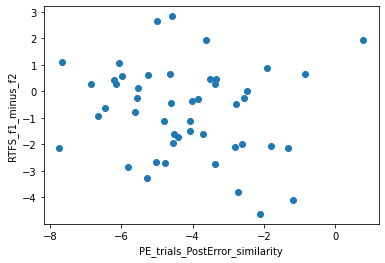

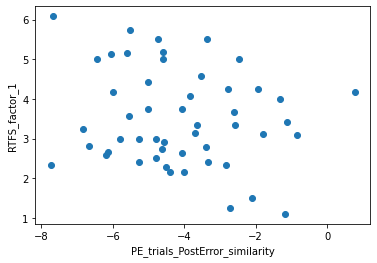

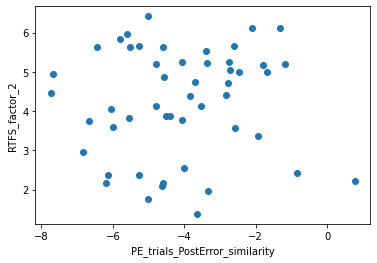

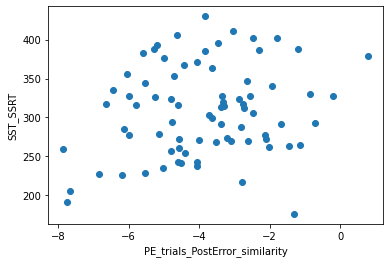

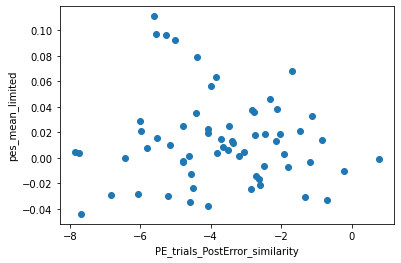

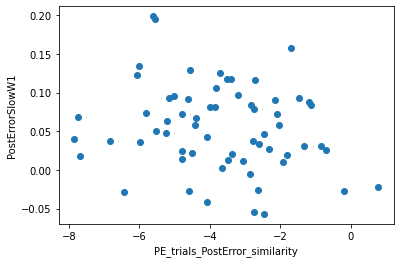

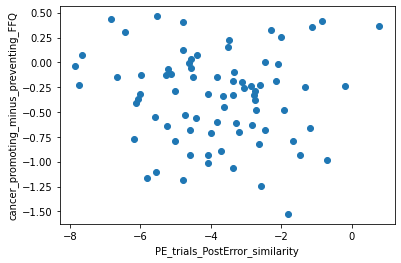

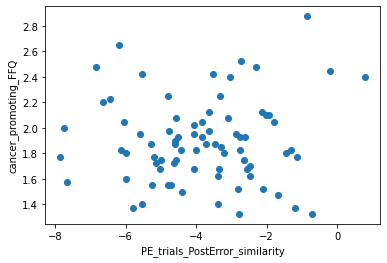

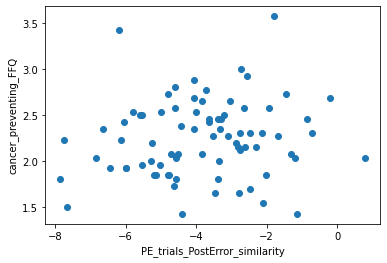

### PC_trials_PostCorrect_similarity

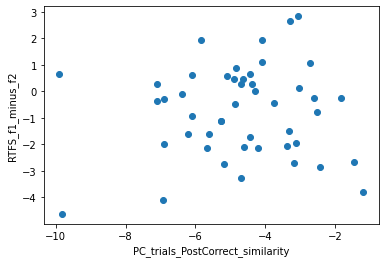

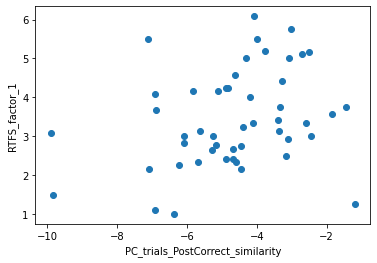

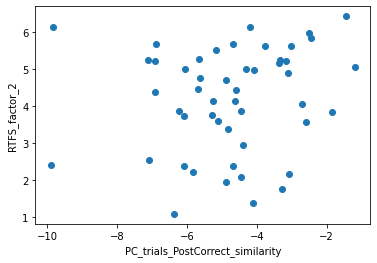

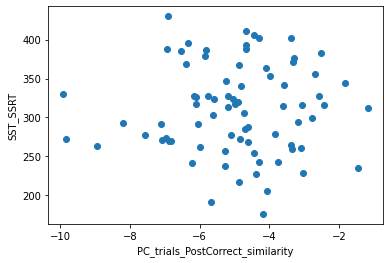

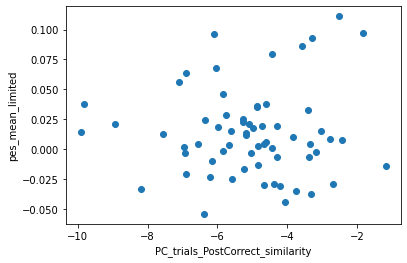

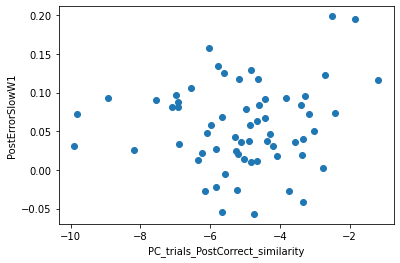

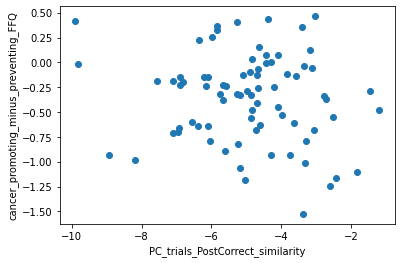

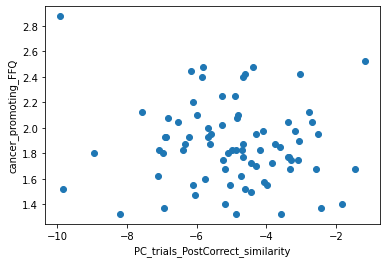

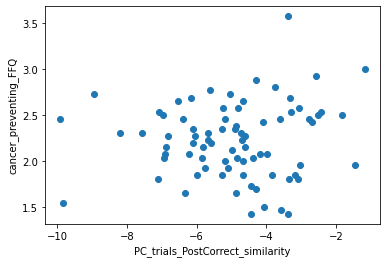

### Female

#### PE_trials_PostError_similarity

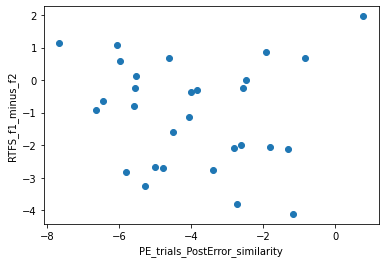

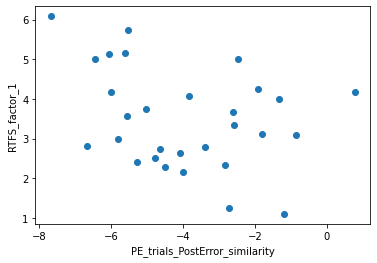

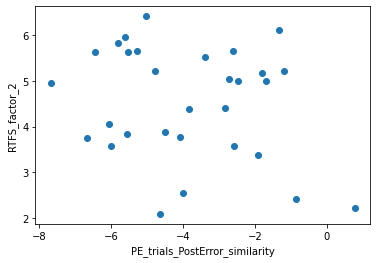

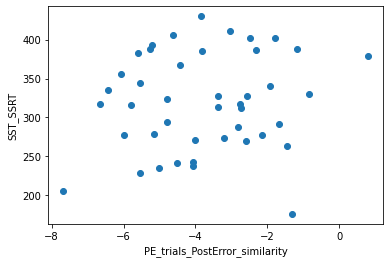

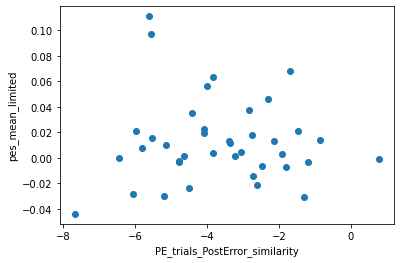

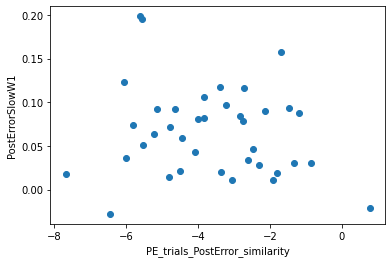

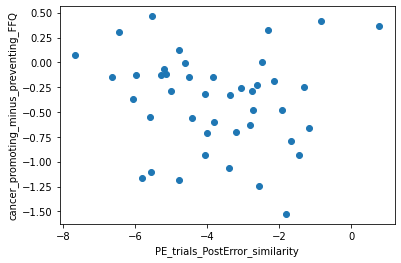

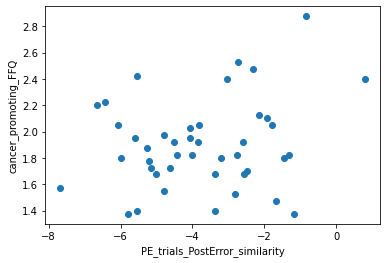

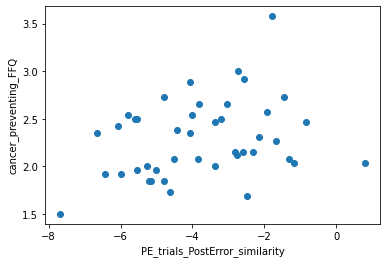

#### PC_trials_PostCorrect_similarity

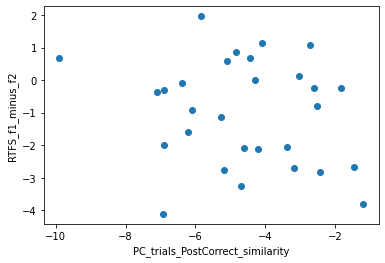

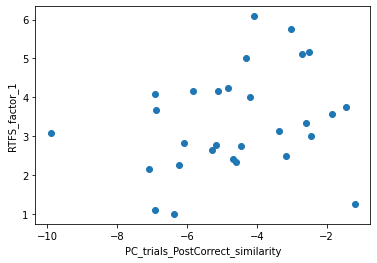

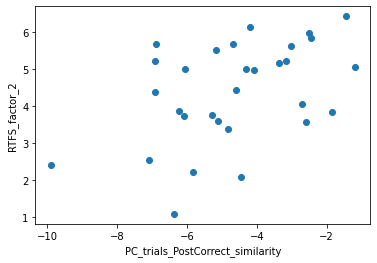

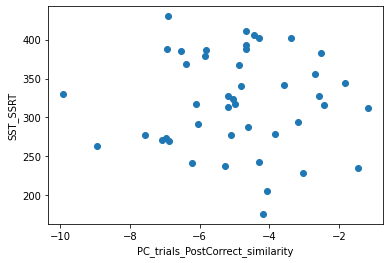

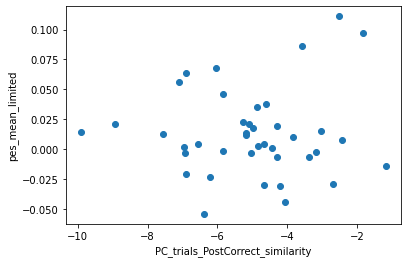

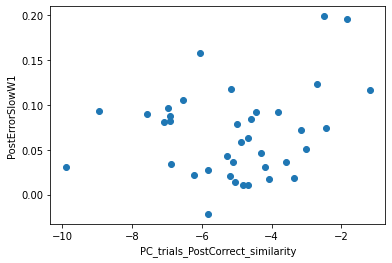

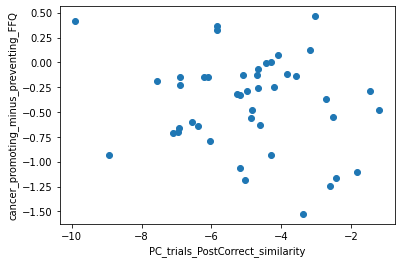

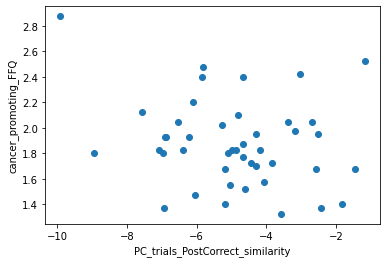

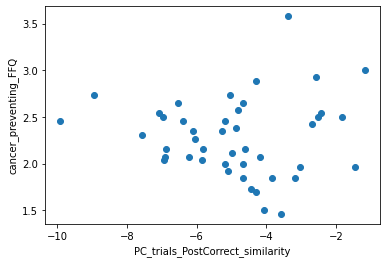

In [15]:
run_full_pes_analysis_no_male_specific('wholebrain',None,'dot_product')

So it might make to focus on female only. just for comparison, how does this look if we try correlation as well as dot product.

These results are not...completely resistant to our p-hacking. we have checked a _lot_ of different items to get here. On the other hand, we were more interested in RTFS than anything else right from the start-this was kind of the hypothesis we were looking at. We have had degrees of freedom in outlier detection and RTFS measure (f1, f2, f2mf1) and the similarity measure that we used.

Still we have the full dataset to go check on; under half of the subjects are fully represented here.

## Correlation

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_wholebrain.pkl
0.8888888888888888
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_wholebrain.pkl
plotting signatures


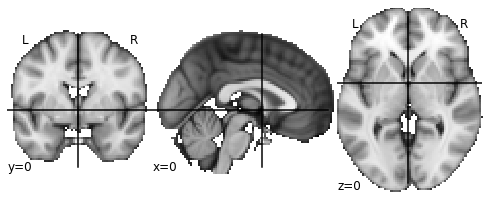

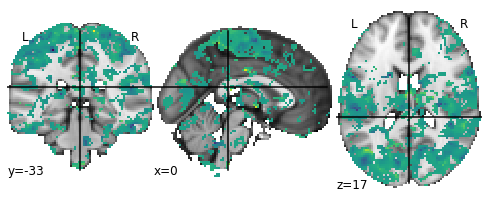

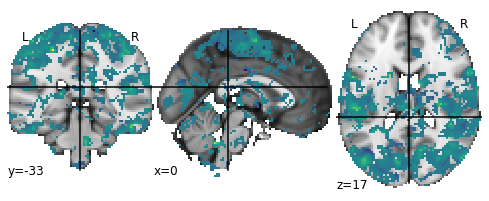

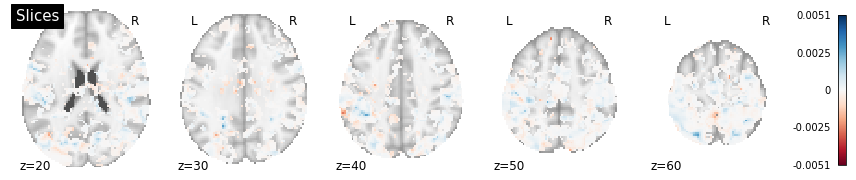

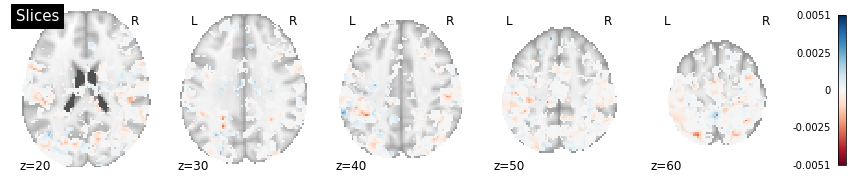

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


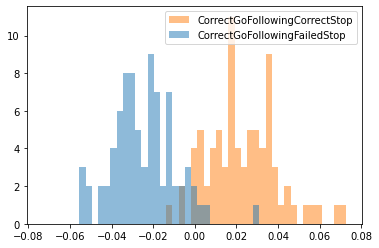

,PostError_similarity,PostCorrect_similarity
condition_label,,
CorrectGoFollowingCorrectStop,0.024332,-0.024332
CorrectGoFollowingFailedStop,-0.025168,0.025168


0.009232456815562565 0.07499674494725306 -0.0657642881316905 0.08422920176281562


0.009232456815562565 0.07499674494725306 -0.0657642881316905 0.08422920176281562
66 , 60
0.00542666014271937 0.07267931990910022 -0.06725265976638085 0.07810598005181958
60 , 59
0.00470075519842794 0.07130647499379199 -0.06660571979536405 0.07600723019221993
59 , 59


66 , 65
65 , 65


0.04934769830378225 0.16000871055522017 -0.11066101225143793 0.20935640885900242


0.04934769830378225 0.16000871055522017 -0.11066101225143793 0.20935640885900242
66 , 64
0.04934769830378225 0.1599415802788834 -0.11059388197510114 0.20928927858266563
64 , 64


66 , 65
65 , 64
64 , 64


1606.8330282933334 4748.65773553835 -3141.8247072450163 6355.490763831684


1606.8330282933334 4748.65773553835 -3141.8247072450163 6355.490763831684
30 , 27
1424.959268 3614.4890078448952 -2189.529739844895 5039.448275844896
27 , 27


30 , 28
28 , 27
27 , 27


0.02176800794977803 0.05622265410602417 -0.034454646156246146 0.0779906620558022


0.02176800794977803 0.05622265410602417 -0.034454646156246146 0.0779906620558022
81 , 80
0.02144431038780497 0.055530205364822054 -0.034085894977017084 0.07697451575262702
80 , 80


81 , 80
80 , 79
79 , 78
78 , 77
77 , 77


-0.025926195985069376 0.044119636947643294 -0.07004583293271267 0.018193440962573918


-0.025926195985069376 0.044119636947643294 -0.07004583293271267 0.018193440962573918
81 , 79
-0.025926195985069376 0.0418519474284575 -0.06777814341352688 0.015925751443388123
79 , 79


81 , 79
79 , 79


-0.02176800794977803 0.05622265410602417 -0.0779906620558022 0.034454646156246146


-0.02176800794977803 0.05622265410602417 -0.0779906620558022 0.034454646156246146
81 , 80
-0.02144431038780497 0.055530205364822054 -0.07697451575262702 0.034085894977017084
80 , 80


81 , 80
80 , 79
79 , 78
78 , 77
77 , 77


0.025926195985069376 0.044119636947643294 -0.018193440962573918 0.07004583293271267


0.025926195985069376 0.044119636947643294 -0.018193440962573918 0.07004583293271267
81 , 79
0.025926195985069376 0.0418519474284575 -0.015925751443388123 0.06777814341352688
79 , 79


81 , 79
79 , 79


### PE_trials_PostError_similarity

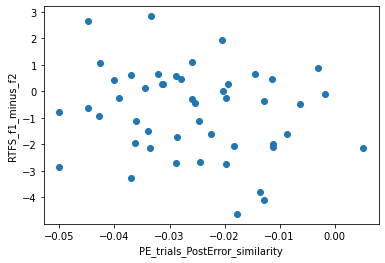

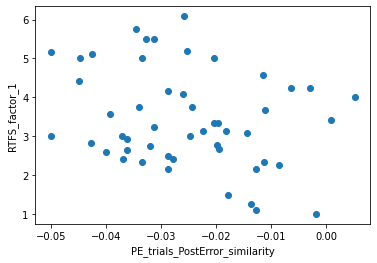

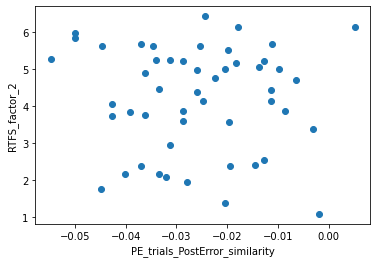

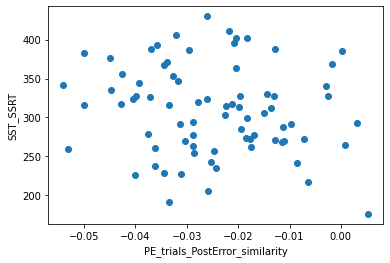

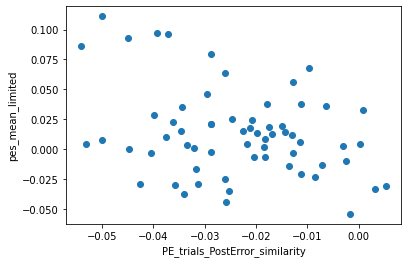

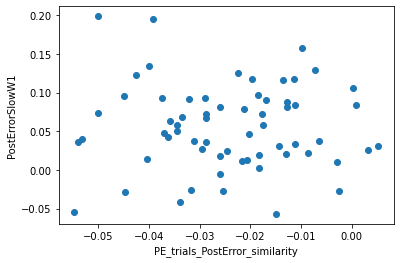

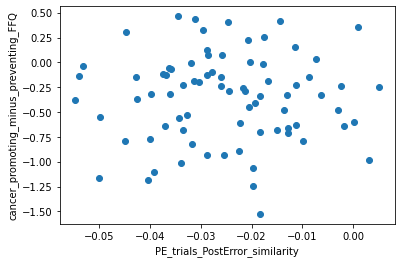

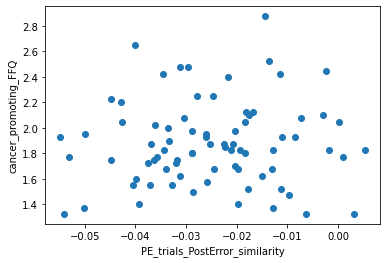

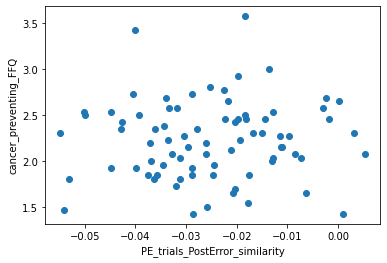

### PC_trials_PostCorrect_similarity

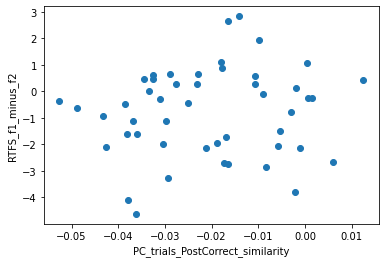

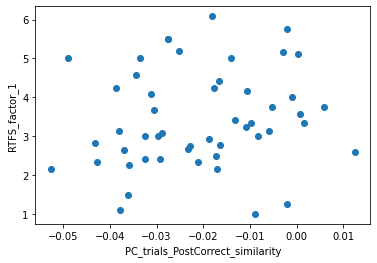

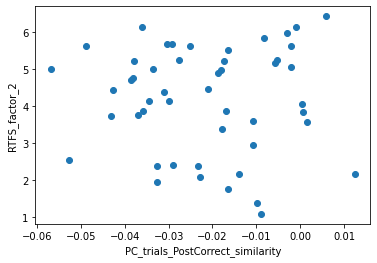

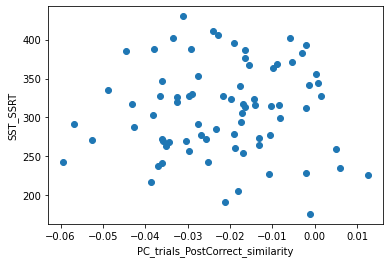

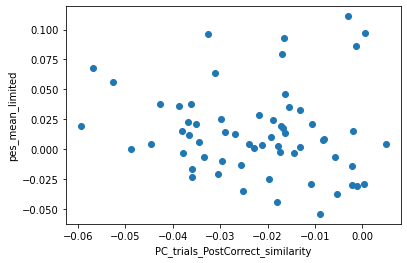

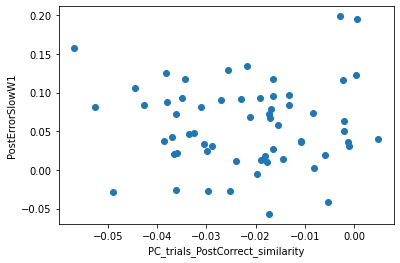

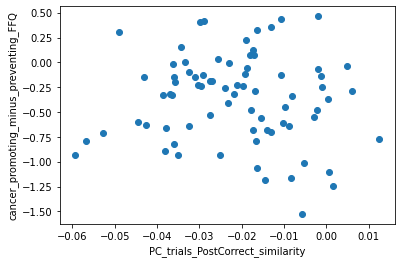

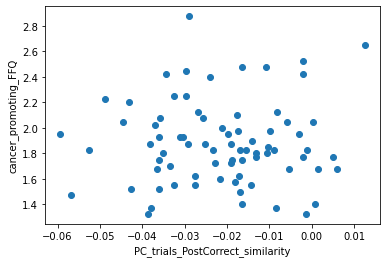

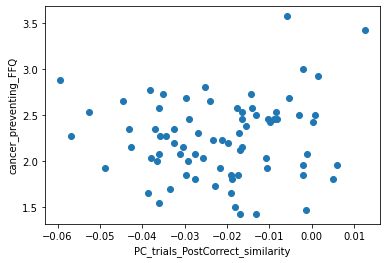

### Female

#### PE_trials_PostError_similarity

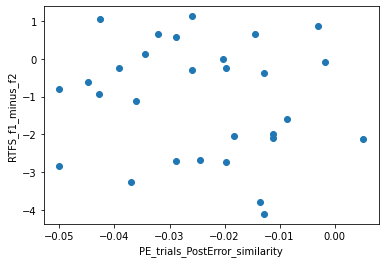

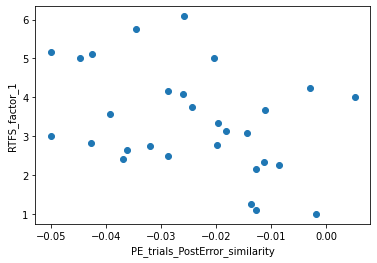

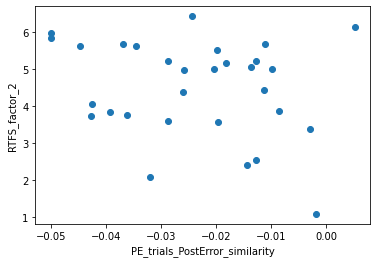

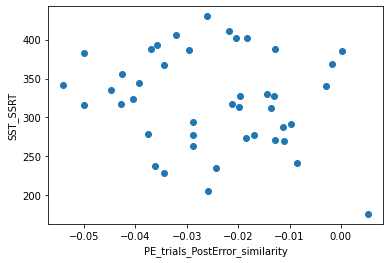

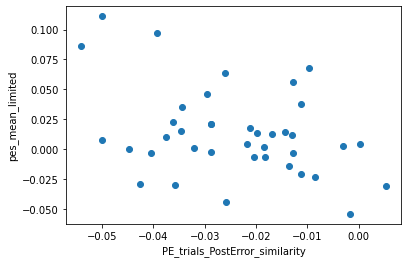

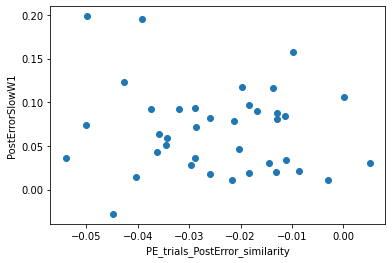

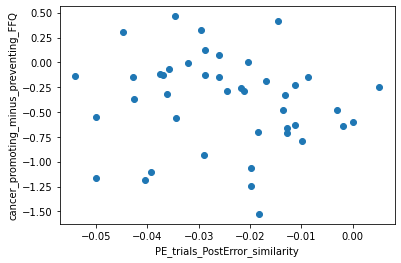

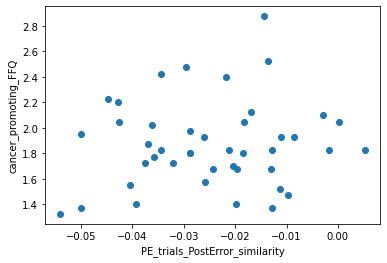

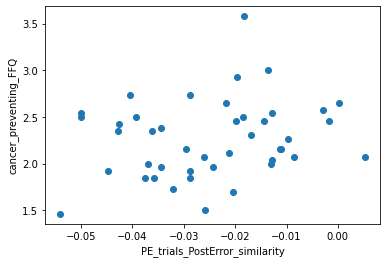

#### PC_trials_PostCorrect_similarity

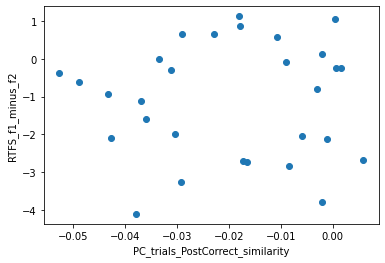

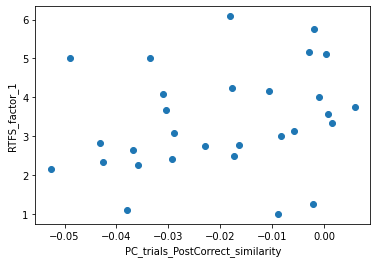

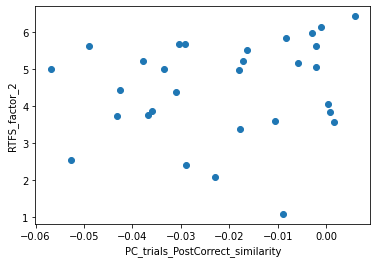

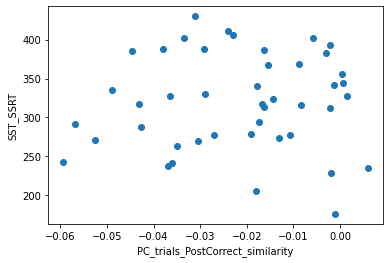

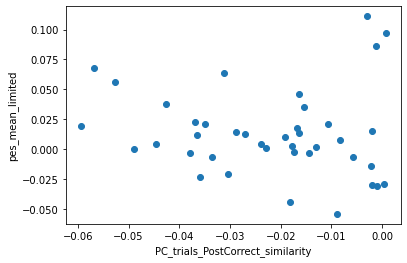

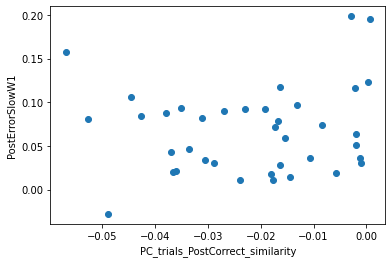

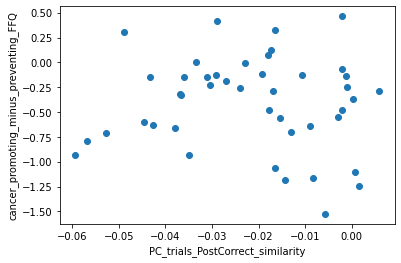

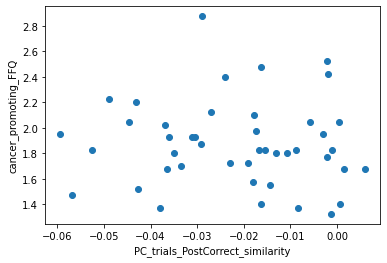

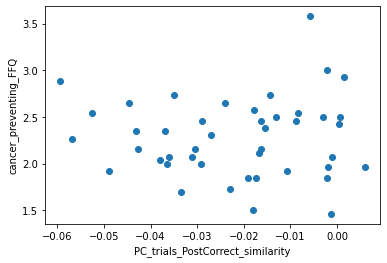

## cosine

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_wholebrain.pkl
0.8888888888888888
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_wholebrain.pkl
plotting signatures


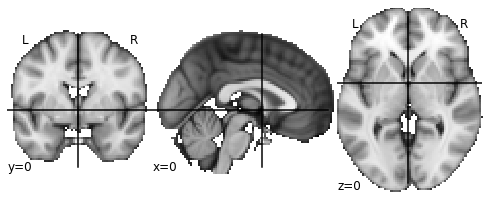

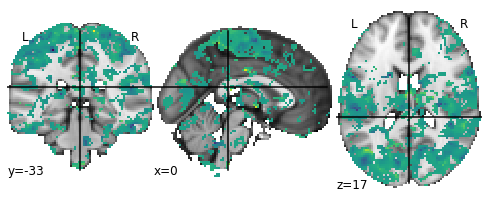

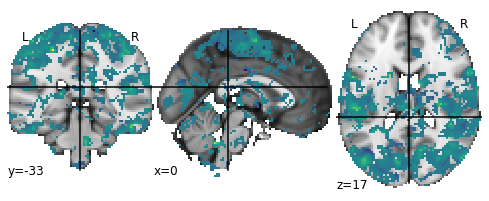

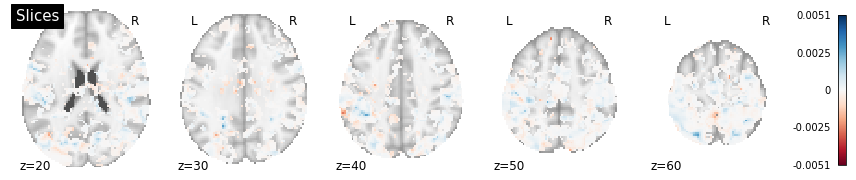

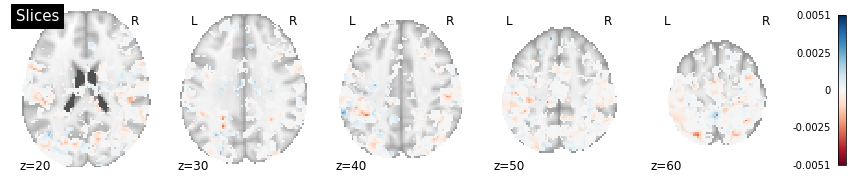

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


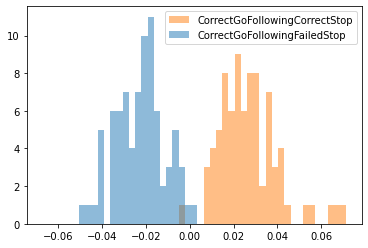

,PostError_similarity,PostCorrect_similarity
condition_label,,
CorrectGoFollowingCorrectStop,0.027660,-0.027660
CorrectGoFollowingFailedStop,-0.023124,0.023124


0.009232456815562565 0.07499674494725306 -0.0657642881316905 0.08422920176281562


0.009232456815562565 0.07499674494725306 -0.0657642881316905 0.08422920176281562
66 , 60
0.00542666014271937 0.07267931990910022 -0.06725265976638085 0.07810598005181958
60 , 59
0.00470075519842794 0.07130647499379199 -0.06660571979536405 0.07600723019221993
59 , 59


66 , 65
65 , 65


0.04934769830378225 0.16000871055522017 -0.11066101225143793 0.20935640885900242


0.04934769830378225 0.16000871055522017 -0.11066101225143793 0.20935640885900242
66 , 64
0.04934769830378225 0.1599415802788834 -0.11059388197510114 0.20928927858266563
64 , 64


66 , 65
65 , 64
64 , 64


1606.8330282933334 4748.65773553835 -3141.8247072450163 6355.490763831684


1606.8330282933334 4748.65773553835 -3141.8247072450163 6355.490763831684
30 , 27
1424.959268 3614.4890078448952 -2189.529739844895 5039.448275844896
27 , 27


30 , 28
28 , 27
27 , 27


0.02535646848842646 0.04041018121352167 -0.01505371272509521 0.06576664970194812


0.02535646848842646 0.04041018121352167 -0.01505371272509521 0.06576664970194812
81 , 78
0.024907088921089823 0.03467777951216593 -0.009770690591076103 0.05958486843325575
78 , 77
0.024889478405413633 0.03265752570858683 -0.007768047303173195 0.05754700411400046
77 , 77


81 , 79
79 , 77
77 , 77


-0.021238228550497368 0.03475461188461731 -0.055992840435114676 0.01351638333411994


-0.021238228550497368 0.03475461188461731 -0.055992840435114676 0.01351638333411994
81 , 80
-0.021202887190312273 0.03399786371092662 -0.055200750901238896 0.012794976520614346
80 , 80


81 , 80
80 , 80


-0.02535646848842646 0.04041018121352167 -0.06576664970194812 0.01505371272509521


-0.02535646848842646 0.04041018121352167 -0.06576664970194812 0.01505371272509521
81 , 78
-0.024907088921089823 0.03467777951216593 -0.05958486843325575 0.009770690591076103
78 , 77
-0.024889478405413633 0.03265752570858683 -0.05754700411400046 0.007768047303173195
77 , 77


81 , 79
79 , 77
77 , 77


0.021238228550497368 0.03475461188461731 -0.01351638333411994 0.055992840435114676


0.021238228550497368 0.03475461188461731 -0.01351638333411994 0.055992840435114676
81 , 80
0.021202887190312273 0.03399786371092662 -0.012794976520614346 0.055200750901238896
80 , 80


81 , 80
80 , 80


### PE_trials_PostError_similarity

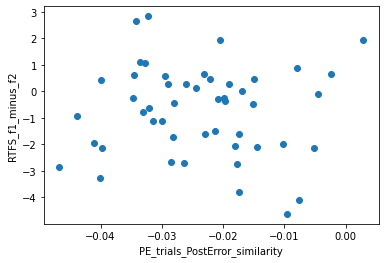

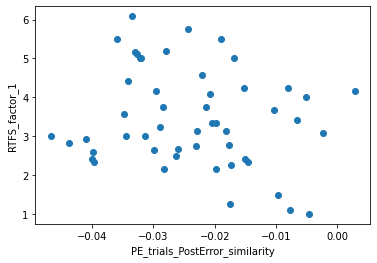

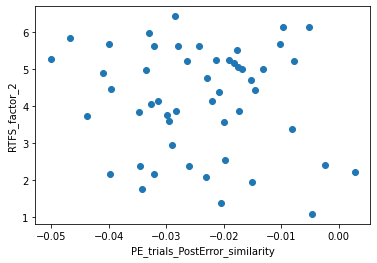

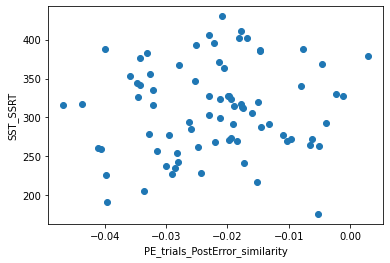

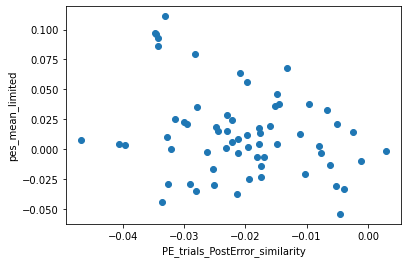

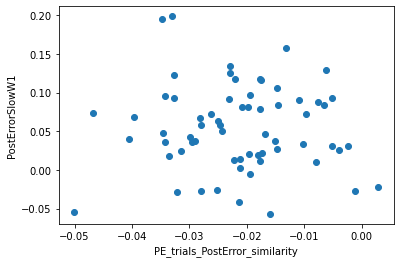

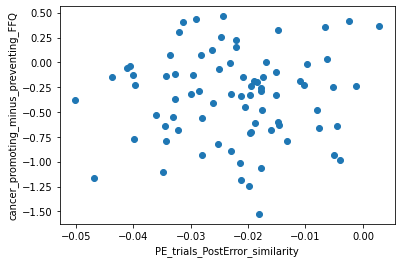

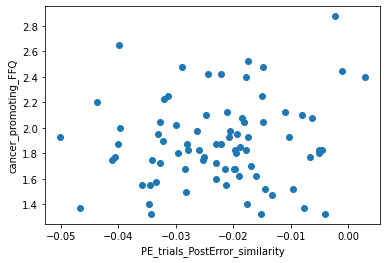

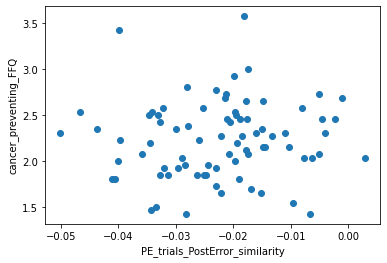

### PC_trials_PostCorrect_similarity

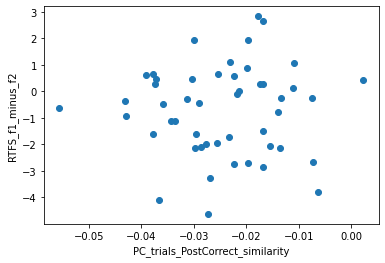

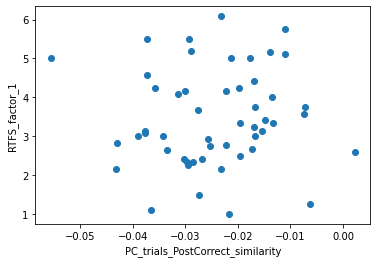

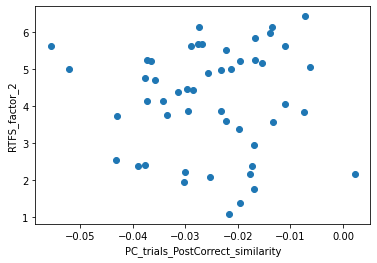

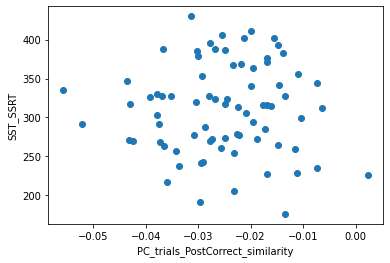

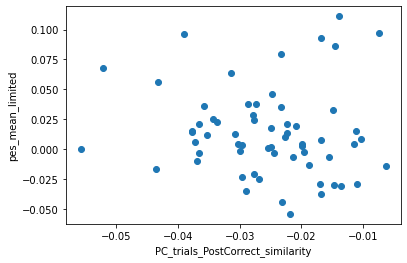

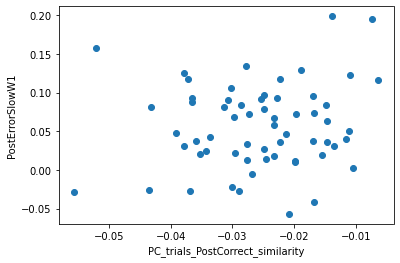

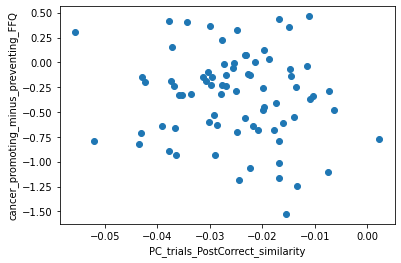

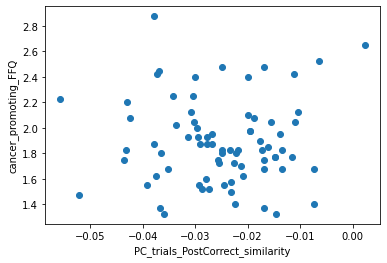

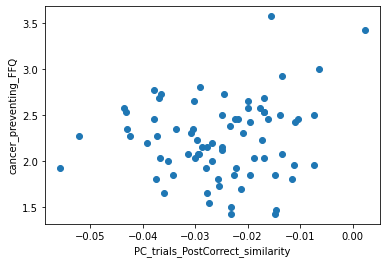

### Female

#### PE_trials_PostError_similarity

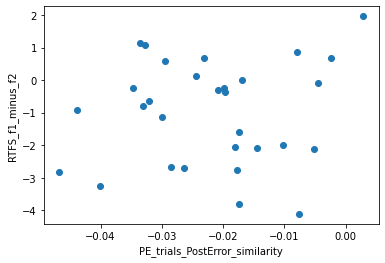

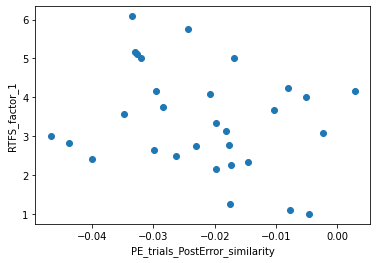

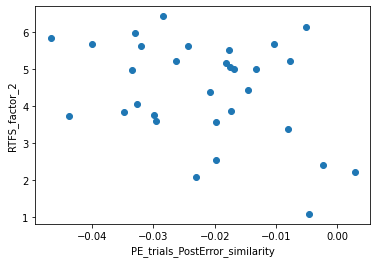

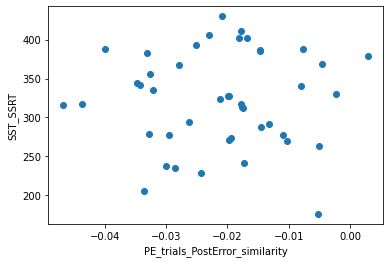

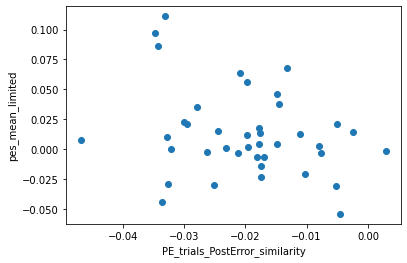

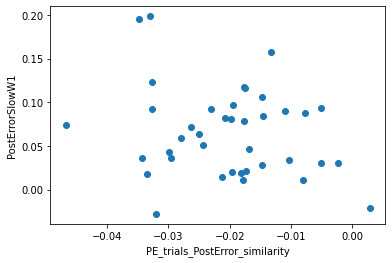

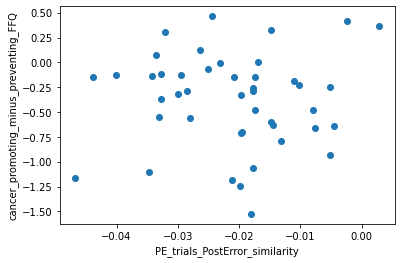

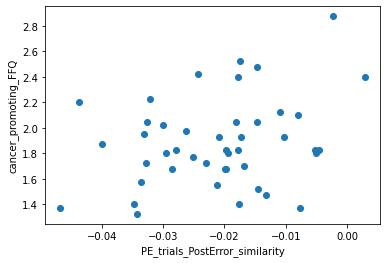

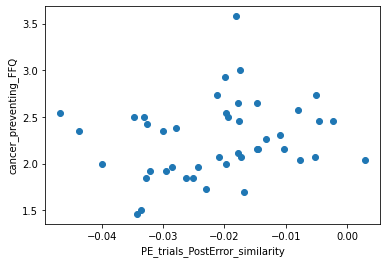

#### PC_trials_PostCorrect_similarity

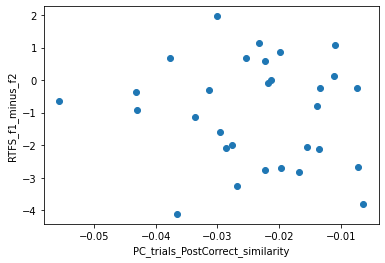

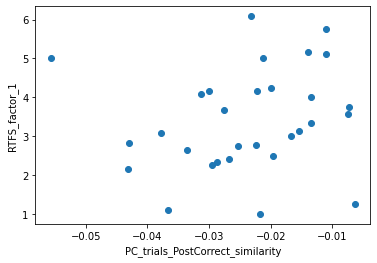

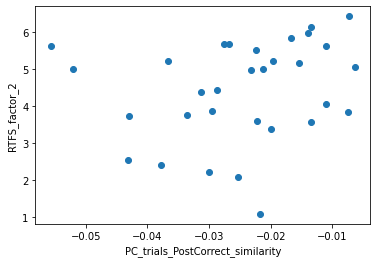

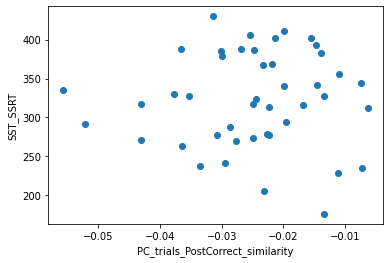

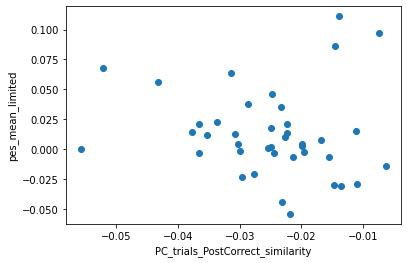

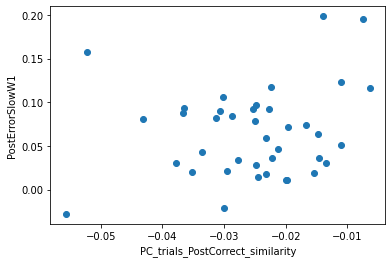

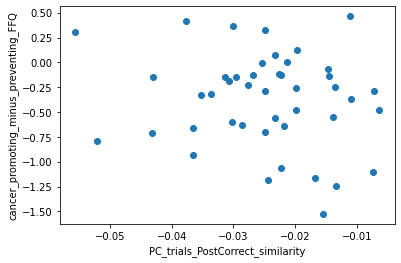

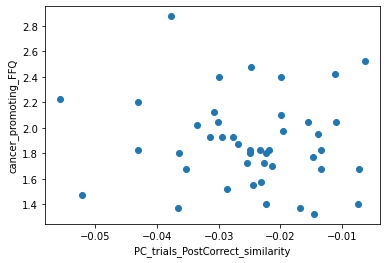

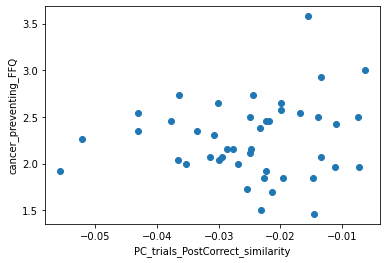

In [16]:
display(Markdown("## " + 'Correlation'))
run_full_pes_analysis_no_male_specific('wholebrain',None,'correlation')
display(Markdown("## " + 'cosine'))
run_full_pes_analysis_no_male_specific('wholebrain',None,'cosine')

## Comparing outlier measures

I don't love the 3SD measure. need to compare them specifically for whole-brain...

In [16]:


def compare_outlier_measures(mask_label,mask_file,similarity_method):
    dataset_mask_label = mask_label
    relevant_mask = mask_file
    results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_84subs_twoclasses_" + dataset_mask_label +".pkl"
    brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_posterror_conditions_84subs_correct_cond.pkl'

    plotting.plot_img(
        relevant_mask,
        threshold='auto',
        cmap='autumn',
        bg_img=background_img)


    print(results_filepath)
    results=pickle.load(open(results_filepath,'rb'))

    print(np.mean(results[0]))

    PostCorrect_ns=results[3]['CorrectGoFollowingCorrectStop']
    #display(Markdown("### CorrectGoFollowingCorrectStop"))
    plotting.plot_img(PostCorrect_ns,threshold='auto',bg_img=background_img)

    PostError_ns=results[3]['CorrectGoFollowingFailedStop']
    #display(Markdown("### CorrectGoFollowingFailedStop"))
    plotting.plot_img(PostError_ns,threshold='auto',bg_img=background_img)

    print(results_filepath,flush=True)

    print("plotting signatures")

    plot_stat_maps(PostError_ns,PostCorrect_ns)

    print("loading data")

    bd=get_bd(brain_data_filepath,PostError_ns,PostCorrect_ns,relevant_mask,similarity_method=similarity_method)

    create_histogram(bd)

    ind_div_combined = get_ind_div_for_pes_combined(bd,ml_data_folderpath)

    ind_div_combined = remove_selected_outliers_rtfs_study(ind_div_combined,show_plot=True)


/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_wholebrain.pkl
0.8888888888888888
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_wholebrain.pkl
plotting signatures


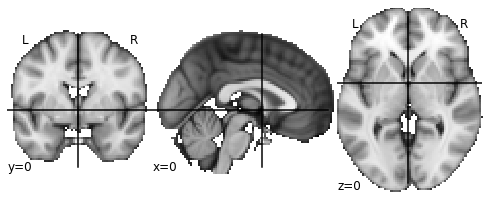

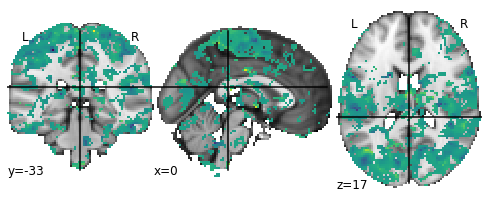

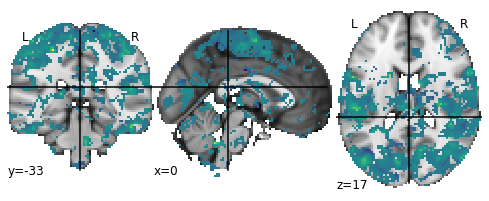

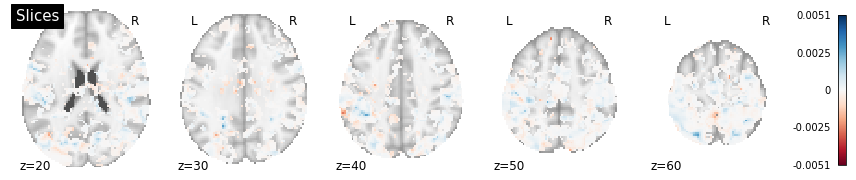

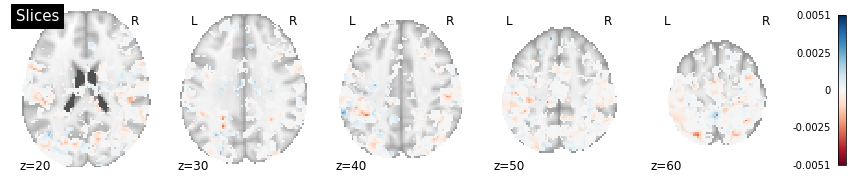

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


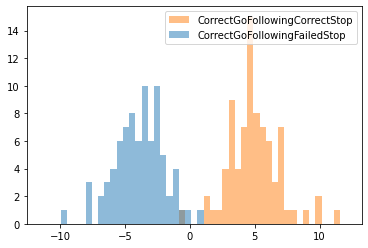

,PostError_similarity,PostCorrect_similarity
condition_label,,
CorrectGoFollowingCorrectStop,4.969145,-4.969145
CorrectGoFollowingFailedStop,-4.627246,4.627246


0.009232456815562565 0.07499674494725306 -0.0657642881316905 0.08422920176281562


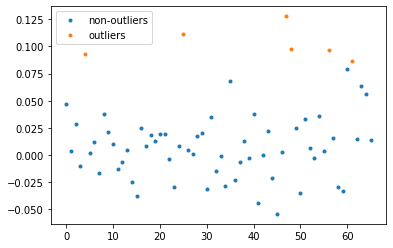

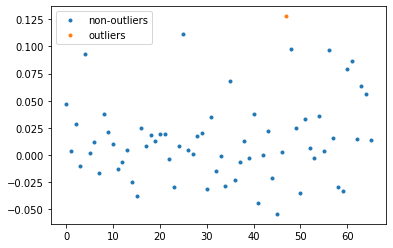

0.009232456815562565 0.07499674494725306 -0.0657642881316905 0.08422920176281562


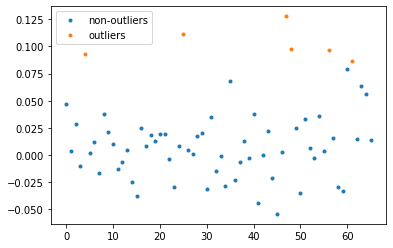

66 , 60
0.00542666014271937 0.07267931990910022 -0.06725265976638085 0.07810598005181958


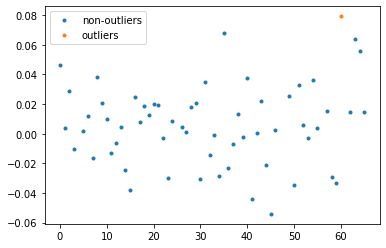

60 , 59
0.00470075519842794 0.07130647499379199 -0.06660571979536405 0.07600723019221993


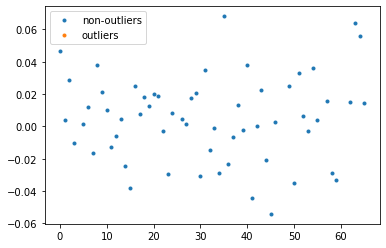

59 , 59


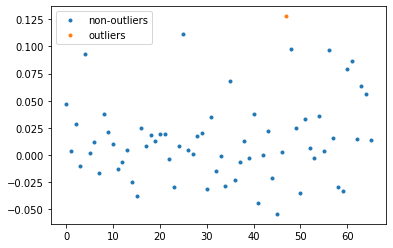

66 , 65


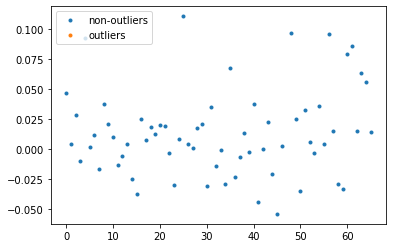

65 , 65


0.04934769830378225 0.16000871055522017 -0.11066101225143793 0.20935640885900242


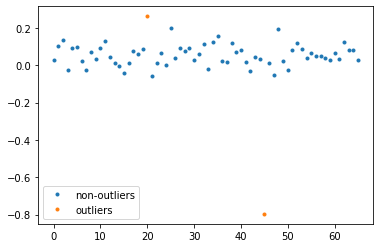

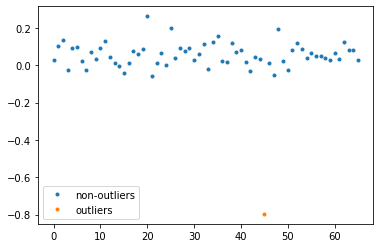

0.04934769830378225 0.16000871055522017 -0.11066101225143793 0.20935640885900242


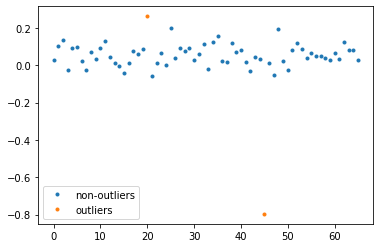

66 , 64
0.04934769830378225 0.1599415802788834 -0.11059388197510114 0.20928927858266563


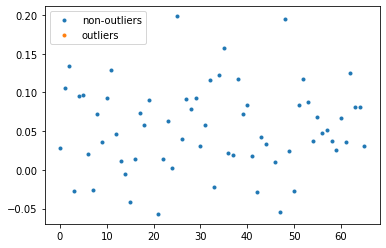

64 , 64


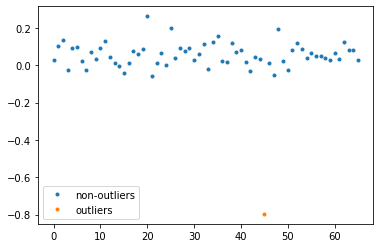

66 , 65


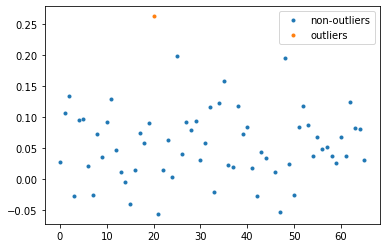

65 , 64


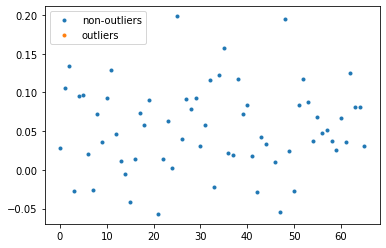

64 , 64


1606.8330282933334 4748.65773553835 -3141.8247072450163 6355.490763831684


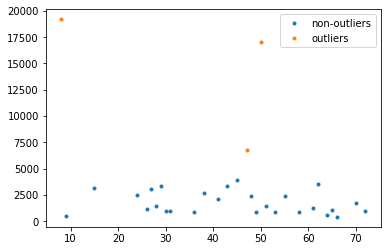

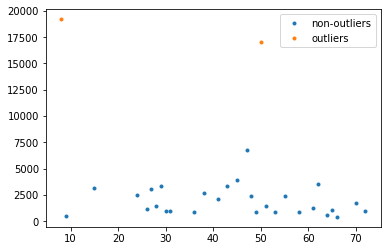

1606.8330282933334 4748.65773553835 -3141.8247072450163 6355.490763831684


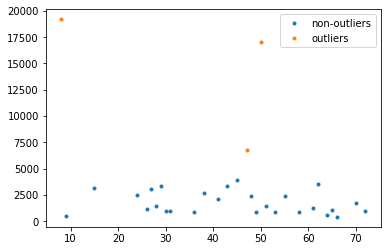

30 , 27
1424.959268 3614.4890078448952 -2189.529739844895 5039.448275844896


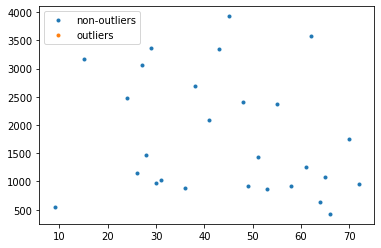

27 , 27


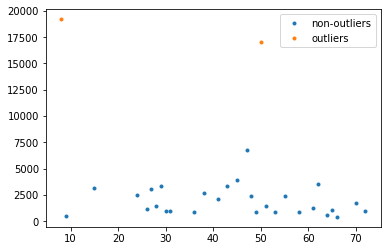

30 , 28


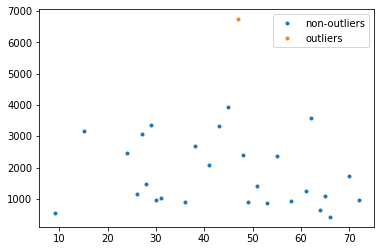

28 , 27


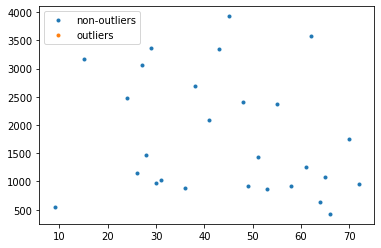

27 , 27


4.872617978045989 5.159237045882512 -0.286619067836523 10.0318550239285


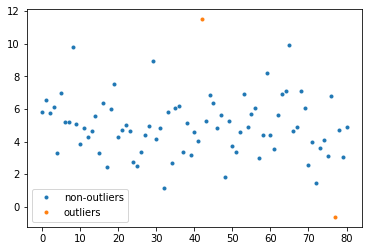

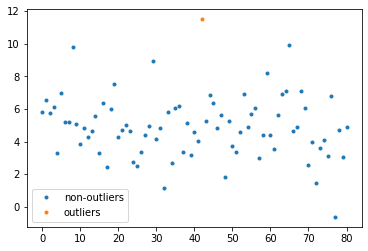

4.872617978045989 5.159237045882512 -0.286619067836523 10.0318550239285


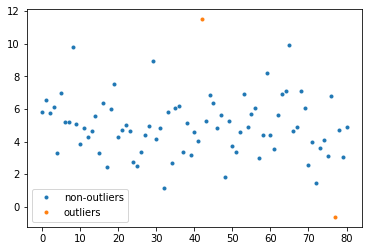

81 , 79
4.872617978045989 5.008704169924817 -0.1360861918788281 9.881322147970806


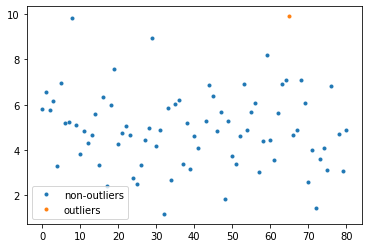

79 , 78
4.8581368636266165 4.778723644000115 0.07941321962650161 9.636860507626732


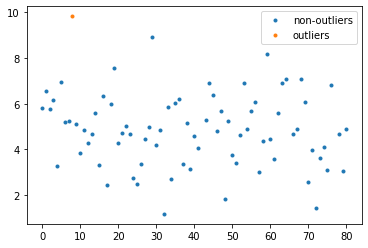

78 , 77
4.843655749207244 4.697860067994084 0.14579568121316022 9.541515817201327


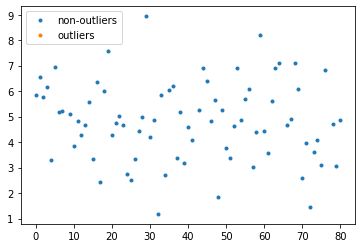

77 , 77


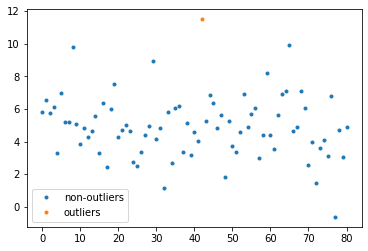

81 , 80


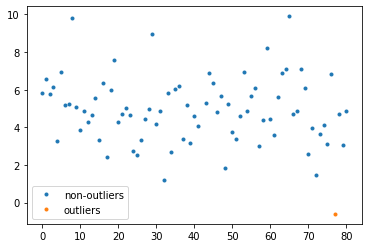

80 , 79


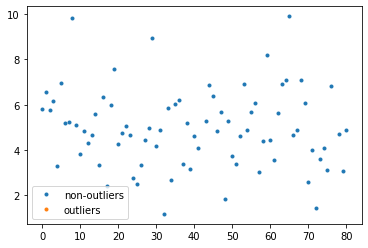

79 , 79


-3.8214337347524667 5.6639886574443405 -9.485422392196806 1.8425549226918738


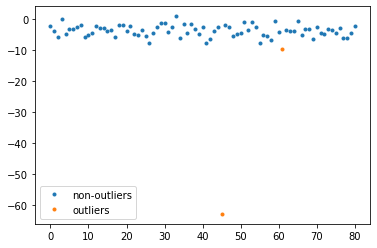

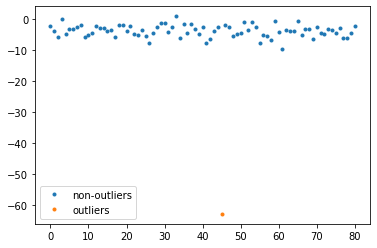

-3.8214337347524667 5.6639886574443405 -9.485422392196806 1.8425549226918738


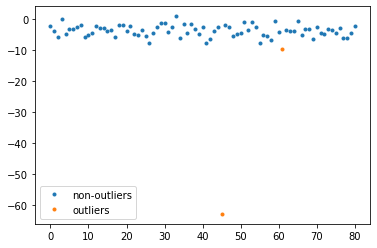

81 , 79
-3.7128407162505654 5.392578321489439 -9.105419037740004 1.6797376052388735


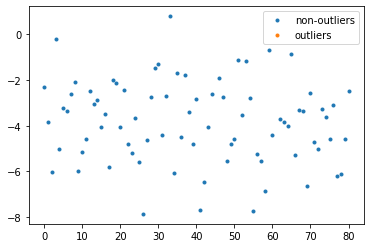

79 , 79


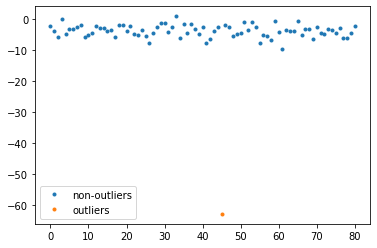

81 , 80


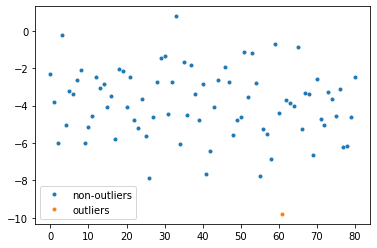

80 , 79


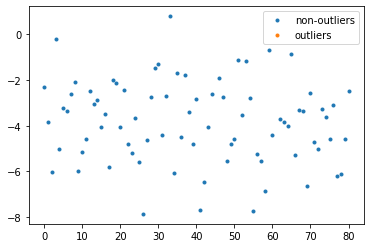

79 , 79


-4.872617978045989 5.159237045882512 -10.0318550239285 0.286619067836523


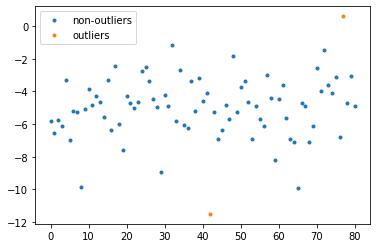

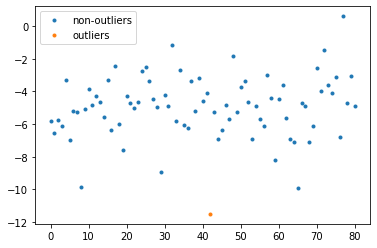

-4.872617978045989 5.159237045882512 -10.0318550239285 0.286619067836523


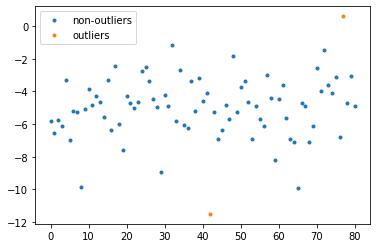

81 , 79
-4.872617978045989 5.008704169924817 -9.881322147970806 0.1360861918788281


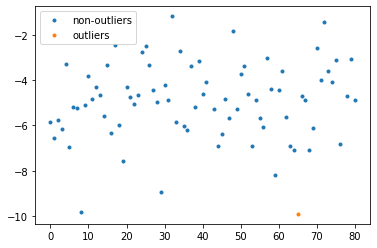

79 , 78
-4.8581368636266165 4.778723644000115 -9.636860507626732 -0.07941321962650161


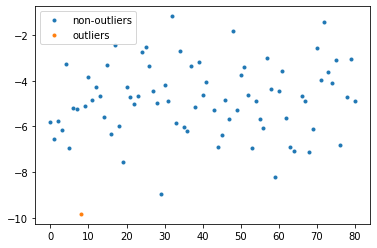

78 , 77
-4.843655749207244 4.697860067994084 -9.541515817201327 -0.14579568121316022


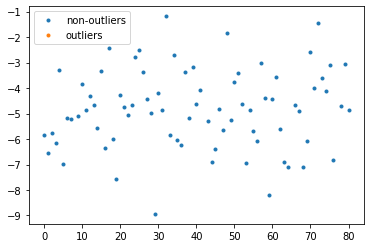

77 , 77


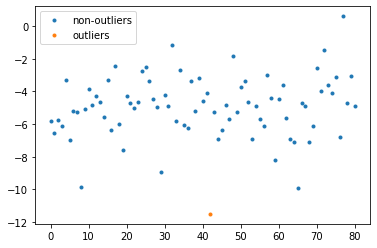

81 , 80


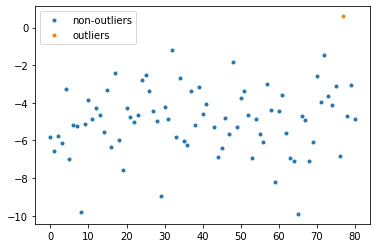

80 , 79


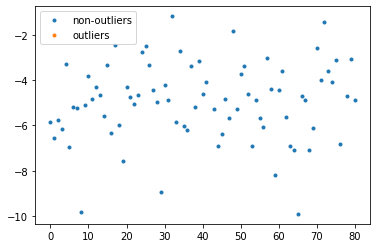

79 , 79


3.8214337347524667 5.6639886574443405 -1.8425549226918738 9.485422392196806


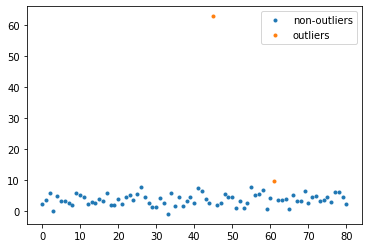

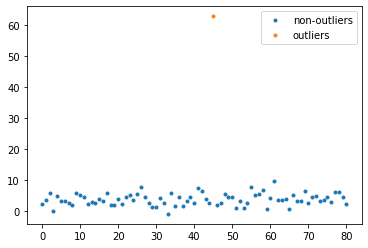

3.8214337347524667 5.6639886574443405 -1.8425549226918738 9.485422392196806


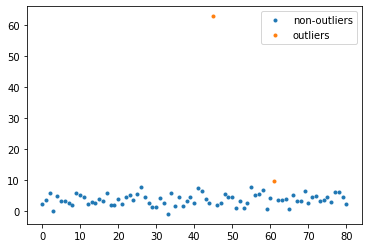

81 , 79
3.7128407162505654 5.392578321489439 -1.6797376052388735 9.105419037740004


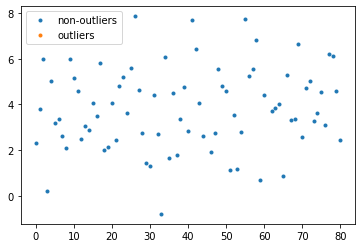

79 , 79


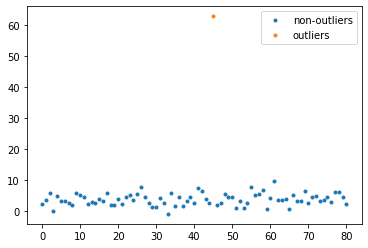

81 , 80


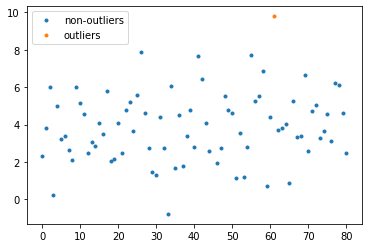

80 , 79


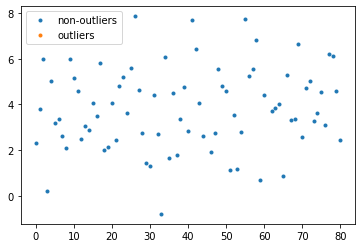

79 , 79


In [36]:
compare_outlier_measures('wholebrain',None,'dot_product')

Apart from IPAQ, 3SD does seem to be more appropriate here.

The recursive algorithm works well, so let's make it the recursive 3SD.

## Contrast

So...the next thing--let's just apply the contrast measure to whole-brain dot product.

We're going to use:

 - 3SD
 - male+female, female only measures
 - whole-brain

In [33]:
from analyze_results import plot_stat_maps

In [34]:
dataset_mask_label = 'wholebrain'
relevant_mask = None
results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_84subs_twoclasses_" + dataset_mask_label +".pkl"
brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_posterror_conditions_84subs_correct_cond.pkl'
brain_data_condition_contrast_filepath = ml_data_folderpath + '/SST/Brain_Data_posterror_conditions_84subs_condition_contrast.pkl'

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_wholebrain.pkl
0.8888888888888888


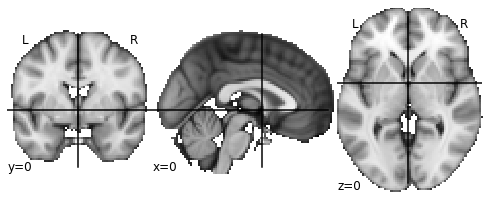

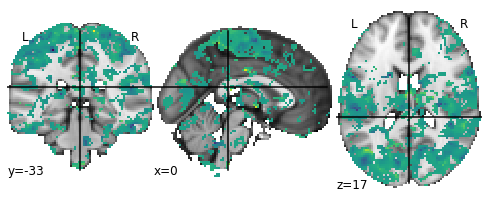

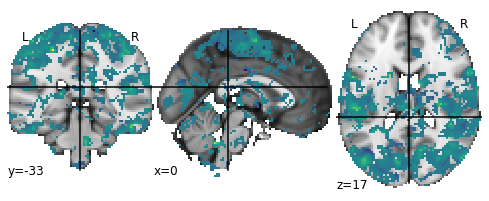

In [35]:
plotting.plot_img(
    relevant_mask,
    threshold='auto',
    cmap='autumn',
    bg_img=background_img)


print(results_filepath)
results=pickle.load(open(results_filepath,'rb'))

print(np.mean(results[0]))

PostCorrect_ns=results[3]['CorrectGoFollowingCorrectStop']
#display(Markdown("### CorrectGoFollowingCorrectStop"))
plotting.plot_img(PostCorrect_ns,threshold='auto',bg_img=background_img)

PostError_ns=results[3]['CorrectGoFollowingFailedStop']
#display(Markdown("### CorrectGoFollowingFailedStop"))
plotting.plot_img(PostError_ns,threshold='auto',bg_img=background_img)

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_wholebrain.pkl
plotting signatures


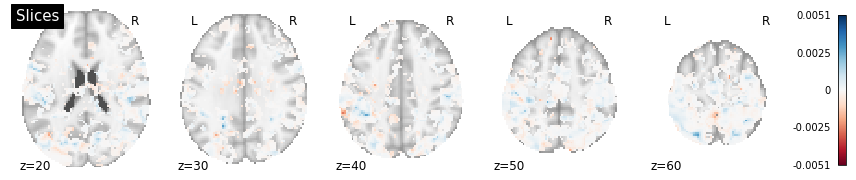

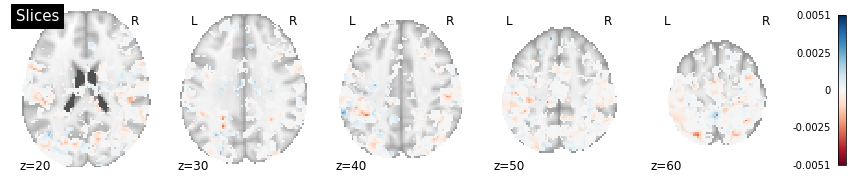

loading data


NameError: name 'brain_data_2_cond_filepath' is not defined

In [36]:
print(results_filepath,flush=True)

print("plotting signatures")

plot_stat_maps(PostError_ns,PostCorrect_ns)

print("loading data")

bd=get_bd(brain_data_2_cond_filepath,PostError_ns,PostCorrect_ns,relevant_mask)



In [ ]:
def create_condition_contrast(bd, condition_contrast_filepath,condition_0_label,condition_1_label):

    bd.X.reset_index(inplace=True,drop=True)

    bd_contrast = None
    for subject in np.unique(bd.X.subject):
        print(subject,end=", ")
        #get all the indices of images with this subject
        #ensure that we have exactly two images for this subject
        subj_indices = bd.X.index[bd.X.subject==subject]
        if len(subj_indices)!=2:
            raise Exception("should be precisely two images for each subject. there wasn't. look into this.")

        subject_bd = bd[subj_indices]
        condition_0_image = subject_bd[subject_bd.X.condition_label==condition_0_label]
        condition_1_image = subject_bd[subject_bd.X.condition_label==condition_1_label]

        subject_failed_stop_minus_correct_stop = condition_1_image - condition_0_image
        #remove items that aren't relevant for the contrast.
        subject_failed_stop_minus_correct_stop.X.drop(['condition_index','condition_label','raw_beta_description','beta'],axis=1,inplace=True)

        if bd_contrast is None:
            bd_contrast = subject_failed_stop_minus_correct_stop
        else:
            bd_contrast = bd_contrast.append(subject_failed_stop_minus_correct_stop)


    bd_contrast.X.reset_index(inplace=True,drop=True)
    
    with open(condition_contrast_filepath, 'wb') as handle:
        pickle.dump(bd_contrast,handle)
        
    return(bd_contrast)
    
bd_contrast = create_condition_contrast(bd, brain_data_condition_contrast_filepath, "CorrectGoFollowingCorrectStop","CorrectGoFollowingFailedStop")

In [ ]:
from matplotlib import pyplot

print("creating histograms")
bins=np.linspace(-0.2,0.3,51) #create histogram bins
pyplot.hist(
    bd_contrast.X.PostError_similarity#.to_numpy()
    ,bins=bins
    ,alpha=0.5,histtype='stepfilled')
pyplot.legend(prop={'size': 10})
pyplot.show();


display(HTML(pd.DataFrame(bd_contrast.X.agg({
    'PostError_similarity':"mean",
    'PostCorrect_similarity':"mean"})).to_html()))

In [ ]:
def get_ind_div_for_pes_combined_contrast(bd,ml_data_folderpath):

    pes_data = pd.read_csv(ml_data_folderpath + "/post_error_slowing.csv",index_col=0)
    pepc_contrast_data = pd.read_csv(ml_data_folderpath + "/post_error_slowing_simple_approach.csv",index_col=0)

    individual_differences = pd.read_csv(ml_data_folderpath + "/data_by_ppt.csv")
    individual_differences = individual_differences.rename(columns={'SID':'subject'})
    individual_differences['wave']=1
    #individual_differences['wave'] = individual_differences['wave'].astype(object) # for compatibility with the wave column in the dataset

    individual_differences = pd.merge(individual_differences,pes_data,how='outer',left_on='subject',right_on='subid')
    individual_differences = pd.merge(individual_differences,pepc_contrast_data,how='outer',left_on='subject',right_on='subid')

    subject_contrast_neural_performance = bd.X.loc[:,['subject','PostError_similarity','PostCorrect_similarity']]

    subject_contrast_neural_performance.columns = ['contrast_trials_' + col for col in subject_contrast_neural_performance.columns]
    subject_contrast_neural_performance =subject_contrast_neural_performance.rename(columns = {'contrast_trials_subject':'subject'})

    ind_div_combined = subject_contrast_neural_performance.merge(individual_differences,left_on='subject',right_on='subject',how='left')
    #ind_div_combined = remove_selected_outliers(ind_div_combined,show_plot=False)
    
    show_plot=True
    ind_div_combined['pes_mean_limited'] = outlier_detection_median_sd(ind_div_combined['pes_mean_limited'],show_plot=show_plot)
    ind_div_combined['PostErrorSlowW1'] = outlier_detection_median_sd(ind_div_combined['PostErrorSlowW1'],show_plot=show_plot)
    ind_div_combined['IPAQ_MET_kCal'] = outlier_detection_median_sd(ind_div_combined['IPAQ_MET_kCal'],show_plot=show_plot)
#    print(ind_div_combined.columns)
    ind_div_combined['contrast_trials_PostError_similarity'] = outlier_detection_median_sd(ind_div_combined['contrast_trials_PostError_similarity'],show_plot=show_plot)
    ind_div_combined['contrast_trials_PostCorrect_similarity'] = outlier_detection_median_sd(ind_div_combined['contrast_trials_PostCorrect_similarity'],show_plot=show_plot)
    
    return(ind_div_combined)


In [37]:
from nilearn import surface
from nilearn import datasets
from nilearn import plotting
from matplotlib import pyplot
from scipy.stats import pearsonr
import pickle
from IPython.core.display import display, HTML, Markdown
from nilearn import plotting
from nilearn.masking import compute_brain_mask
import nltools as nlt
import numpy as np
import pandas as pd

#create_histogram(bd_contrast)

ind_div_combined = get_ind_div_for_pes_combined_contrast(bd_contrast,ml_data_folderpath)

ind_div_combined = remove_selected_outliers_rtfs_study(ind_div_combined,show_plot=False)

for neural_var in ['contrast_trials_PostError_similarity','contrast_trials_PostCorrect_similarity']:
    display(Markdown("### " + neural_var))
    for correlate in ['RTFS_f1_minus_f2','RTFS_factor_1','RTFS_factor_2','SST_SSRT','pes_mean_limited','PostErrorSlowW1','cancer_promoting_minus_preventing_FFQ',
        'cancer_promoting_FFQ','cancer_preventing_FFQ']:
        visualize_corr(neural_var,correlate,ind_div_combined)

for bs_f in ['Female']:
    display(Markdown("### " + bs_f))
    for neural_var in ['contrast_trials_PostError_similarity','contrast_trials_PostCorrect_similarity']:
        display(Markdown("#### " + neural_var))
        for correlate in ['RTFS_f1_minus_f2','RTFS_factor_1','RTFS_factor_2','SST_SSRT','pes_mean_limited','PostErrorSlowW1','cancer_promoting_minus_preventing_FFQ',
    'cancer_promoting_FFQ','cancer_preventing_FFQ']:
            visualize_corr(neural_var,correlate,ind_div_combined.loc[ind_div_combined.birthsex_factor==bs_f,:])




NameError: name 'get_ind_div_for_pes_combined_contrast' is not defined

In [24]:
ind_div_combined

NameError: name 'ind_div_combined' is not defined